# Expedia Hotel Recommendation

Data Description

Expedia has provided you logs of customer behavior. These include what customers searched for, how they interacted with search results (click/book), whether or not the search result was a travel package. The data in this competition is a random selection from Expedia and is not representative of the overall statistics.

Expedia is interested in predicting which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together. These hotel clusters serve as good identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.

Your goal of this competition is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event.

The train and test datasets are split based on time: training data from 2013 and 2014, while test data are from 2015. The public/private leaderboard data are split base on time as well. Training data includes all the users in the logs, including both click events and booking events. Test data only includes booking events. 

destinations.csv data consists of features extracted from hotel reviews text. 

Note that some srch_destination_id's in the train/test files don't exist in the destinations.csv file. This is because some hotels are new and don't have enough features in the latent space. Your algorithm should be able to handle this missing information.

In [1]:
# train/test.csv

# date_time(string) : Timestamp 
# site_name(int) : ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ...)
# posa_continent(int) : ID of continent associated with site_name
# user_location_country(int) : The ID of the country the customer is located
# user_location_region(int) : The ID of the region the customer is located
# user_location_city(int) : The ID of the city the customer is located
# orig_destination_distance(double) : Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated	double
# user_id(int) : ID of user
# is_mobile(tinyint) : 1 when a user connected from a mobile device, 0 otherwise
# is_package(int) : 1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise
# channel(int) : ID of a marketing channel
# srch_ci(string) : Checkin date
# srch_co(string) : Checkout date
# srch_adults_cnt(int) : The number of adults specified in the hotel room
# srch_children_cnt(int) : The number of (extra occupancy) children specified in the hotel room
# srch_rm_cnt(int) : The number of hotel rooms specified in the search
# srch_destination_id(int) : ID of the destination where the hotel search was performed
# srch_destination_type_id(int) : Type of destination
# hotel_continent(int) : Hotel continent
# hotel_country(int) : Hotel country
# hotel_market(int) : Hotel market
# is_booking(tinyint) : 1 if a booking, 0 if a click
# cnt(bigint) : Numer of similar events in the context of the same user session
# hotel_cluster(int) : ID of a hotel cluster

# 1. Data preprocessing & EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import missingno as msno
import ml_metrics as metrics

In [2]:
destinations = pd.read_csv("destinations.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

### Check Dataset

In [3]:
print('train.shape :', train.shape)
print('test.shape :', test.shape)
print('destinations.shape', destinations.shape)

train.shape : (37670293, 24)
test.shape : (2528243, 22)
destinations.shape (62106, 150)


- train set 너무 많음(3700만 개) --> 이대로 계속 분석 가능한지?(메모리 이슈) : sampling

In [4]:
# check destinationmissing values
print(destinations.tail())
print(train.tail())
print(train.info())
print(test.tail())
print(test.info())

       srch_destination_id        d1        d2        d3        d4        d5  \
62101                64989 -2.145876 -2.158016 -2.216621 -2.158016 -2.006209   
62102                64990 -2.203479 -2.203479 -2.203479 -2.203479 -2.203479   
62103                64991 -2.190567 -2.208308 -2.208308 -2.208308 -2.208308   
62104                64992 -2.173686 -2.173686 -2.173686 -2.173686 -2.173686   
62105                64993 -2.179457 -2.179457 -2.179457 -2.179457 -2.179457   

             d6        d7        d8        d9  ...      d140      d141  \
62101 -2.102505 -2.216621 -2.157203 -2.216621  ... -2.216621 -2.158016   
62102 -2.176802 -2.203479 -2.203479 -2.203479  ... -2.203479 -2.203479   
62103 -2.135493 -2.208308 -2.208308 -1.909808  ... -2.188935 -2.208308   
62104 -2.173686 -2.173686 -2.173686 -2.173686  ... -2.173686 -2.173686   
62105 -2.179457 -2.179457 -2.179457 -2.179457  ... -2.179457 -2.179457   

           d142      d143      d144      d145      d146      d147      d14

- destination.csv
    - row index와 srch_destination_id가 차이나는 것으로 보아, missing된 id가 존재하는 것으로 판단 (대략 5% 미만) -> 어떻게 처리할지? : 비율이 적어 삭제해도 무방할 듯
- train.csv
    - 대부분 integer, float variable
    - date time는 년,월,일,시 등으로 format 변경 필요
    - user_loaction_country, user_location_city value의 정확한 의미 알 수 없어 사용이 어려워 보임 (keep)
    - orig_destination_distance Nan 어떻게 처리할지? --> data description에 의하면 Nan value는 계산이 불가능한 경우 :
        - A null means the distance could not be calculated

In [5]:
# train.describe()

In [6]:
# test.describe()

In [7]:
# print(len(train.columns), train.columns)
# print(len(test.columns), test.columns)

### Check missing values in data 

In [14]:
def check_nan(df):
    for col in df.columns:
        msg = '{:>10}\t\t\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df[col].isnull().sum() / df[col].shape[0]))
        print(msg)
        
print(check_nan(train))
print(check_nan(test))

 date_time			 Percent of NaN value: 0.00%
 site_name			 Percent of NaN value: 0.00%
posa_continent			 Percent of NaN value: 0.00%
user_location_country			 Percent of NaN value: 0.00%
user_location_region			 Percent of NaN value: 0.00%
user_location_city			 Percent of NaN value: 0.00%
orig_destination_distance			 Percent of NaN value: 35.90%
   user_id			 Percent of NaN value: 0.00%
 is_mobile			 Percent of NaN value: 0.00%
is_package			 Percent of NaN value: 0.00%
   channel			 Percent of NaN value: 0.00%
   srch_ci			 Percent of NaN value: 0.12%
   srch_co			 Percent of NaN value: 0.12%
srch_adults_cnt			 Percent of NaN value: 0.00%
srch_children_cnt			 Percent of NaN value: 0.00%
srch_rm_cnt			 Percent of NaN value: 0.00%
srch_destination_id			 Percent of NaN value: 0.00%
srch_destination_type_id			 Percent of NaN value: 0.00%
is_booking			 Percent of NaN value: 0.00%
       cnt			 Percent of NaN value: 0.00%
hotel_continent			 Percent of NaN value: 0.00%
hotel_country			 Percent of 

- Train.csv column
    - ID 없음
- test.csv column
    - missing value 없음
    - is_booking, cnt, hotel_cluster(label) column 없음

In [19]:
def check_nan_col(df, col_list):
    for cl in col_list:
        Nan_idx = list(df.loc[df[cl].isnull()][cl].index)
        print('Nan of', cl, ': ', len(Nan_idx))

# train에만 결측치 있음
print(check_nan_col(train, ['srch_ci', 'srch_co']))

Nan of srch_ci :  47083
Nan of srch_co :  47084
None


- Checkin data와 Checkout data의 누락이 대부분 겹치치만, 각각 누락된 것도 있음

In [20]:
# delete srch_ci, srch_co nan row 
def delete_nan_col(df, col_list):
    df.dropna(subset=col_list, axis=0, inplace=True)
    
delete_nan_col(train, ['srch_ci', 'srch_co'])
print(check_nan_col(train, ['srch_ci', 'srch_co']))

Nan of srch_ci :  0
Nan of srch_co :  0
None


- srch_ci, srch_co 결측치 삭제 완료

In [21]:
# msno.bar(df=train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))
# msno.matrix(df=train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))
# msno.bar(df=test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))
# msno.matrix(df=test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

### Check target label

In [22]:
train['hotel_cluster'].value_counts()

91    1042562
41     771819
48     753308
64     703398
65     670320
       ...   
35     138967
53     134517
88     107729
27     104795
74      48276
Name: hotel_cluster, Length: 100, dtype: int64

48276 1042562


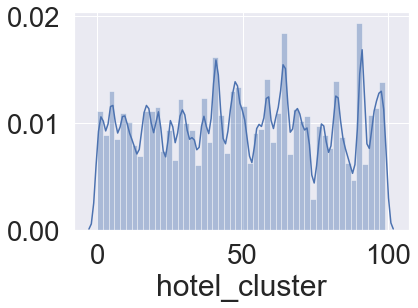

In [23]:
sns.distplot(train['hotel_cluster'])
print(min(train['hotel_cluster'].value_counts()), max(train['hotel_cluster'].value_counts()))

### Convert Dates to Year & Month for original Train/Test set

In [24]:
train['date_time'] = pd.to_datetime(train['date_time'])
train['year'] = train['date_time'].dt.year
train['month'] = train['date_time'].dt.month
train['day'] = train['date_time'].dt.day
print(train.head())

test['date_time'] = pd.to_datetime(test['date_time'])
test['year'] = test['date_time'].dt.year
test['month'] = test['date_time'].dt.month
test['day'] = test['date_time'].dt.day
print(test.head())

            date_time  site_name  posa_continent  user_location_country  \
0 2014-08-11 07:46:59          2               3                     66   
1 2014-08-11 08:22:12          2               3                     66   
2 2014-08-11 08:24:33          2               3                     66   
3 2014-08-09 18:05:16          2               3                     66   
4 2014-08-09 18:08:18          2               3                     66   

   user_location_region  user_location_city  orig_destination_distance  \
0                   348               48862                  2234.2641   
1                   348               48862                  2234.2641   
2                   348               48862                  2234.2641   
3                   442               35390                   913.1932   
4                   442               35390                   913.6259   

   user_id  is_mobile  is_package  ...  srch_destination_type_id is_booking  \
0       12          0    

### Downsizing dataset (by User random sampling)

In [26]:
train_userid_group = train.groupby(['user_id'])['hotel_cluster'].value_counts()
# print(userid_group)
print('[train] unique user count :',train['user_id'].nunique())
print('[test] unique user count :',test['user_id'].nunique())

[train] unique user count : 1198671
[test] unique user count : 1181577


- 1,198,786 user -> 40,000 user random sampling (Considering computation resource)

In [32]:
def random_sampling(df, key_col, sampling_size, origin_file, chunk_size):
    unique_set = set(df[key_col].unique())
    sampling_set = random.sample(unique_set, sampling_size)

    df_sampling = pd.DataFrame()
    df_chunking = pd.read_csv(origin_file, chunksize = chunk_size)

    for c in df_chunking:
        df_sampling = df_sampling.append(c.loc[c[key_col].isin(sampling_set)])
        
    return df_sampling

In [33]:
train_sampling = random_sampling(df=train, key_col='user_id', sampling_size=40000, origin_file='train.csv', chunk_size=100000)
print('sampling unique user count :',train_sampling['user_id'].nunique())    

sampling unique user count : 40000


In [34]:
train_sampling['date_time'] = pd.to_datetime(train_sampling['date_time'])
train_sampling['year'] = train_sampling['date_time'].dt.year
train_sampling['month'] = train_sampling['date_time'].dt.month
train_sampling['day'] = train_sampling['date_time'].dt.day
train_sampling.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,day
869,2013-09-05 11:54:48,24,2,3,51,42966,NaN,5736,0,0,...,1,0,1,0,63,1193,60,2013,9,5
870,2013-09-05 16:34:20,24,2,3,51,42966,NaN,5736,0,0,...,1,0,1,0,63,1193,60,2013,9,5
871,2013-09-10 10:54:13,17,1,133,12,45238,NaN,5736,1,1,...,1,0,1,6,208,951,9,2013,9,10
872,2014-03-06 11:12:19,17,1,133,12,12040,NaN,5736,0,1,...,1,0,1,6,105,1871,78,2014,3,6
873,2014-04-18 10:21:50,17,1,133,29,1493,NaN,5736,0,1,...,1,0,3,6,31,304,67,2014,4,18


In [35]:
# delete srch_ci, srch_co nan row in train_sampling
train_sampling.dropna(subset=['srch_ci', 'srch_co'], axis=0, inplace=True)

In [36]:
# orig_destination_distance 
print(train_sampling['orig_destination_distance'].median(skipna=True))
print(train_sampling['orig_destination_distance'].mean(skipna=True))
train_sampling['orig_destination_distance'].describe()

1127.9766
1963.9830874933068


count    805242.000000
mean       1963.983087
std        2232.087909
min           0.005600
25%         308.764100
50%        1127.976600
75%        2554.197550
max       11754.347300
Name: orig_destination_distance, dtype: float64

In [37]:
train_sampling.groupby(['user_id'])['orig_destination_distance'].describe()

,count,mean,std,min,25%,50%,75%,max
user_id,,,,,,,,
20,7.0,3221.241000,257.219456,2844.7103,3108.173850,3371.85790,3371.923700,3371.9237
24,8.0,5304.388637,4112.171319,2323.6839,2324.639550,2325.65220,10270.230500,10270.4606
33,42.0,1268.526440,1996.638346,5.5150,83.888700,871.64320,874.803625,7914.3079
46,19.0,536.234616,284.287835,307.9156,308.213400,407.53840,716.265250,996.7491
70,3.0,129.519400,1.490588,127.7998,129.057550,130.31530,130.379200,130.4431
...,...,...,...,...,...,...,...,...
1198679,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1198680,98.0,2396.965715,103.222922,2310.0683,2340.146475,2349.61190,2447.061875,2787.4195
1198725,28.0,759.063521,333.472342,137.6257,733.652900,863.56835,863.996800,1174.4383


In [38]:
hotel_distance = train_sampling.groupby(['hotel_cluster'])['orig_destination_distance'].describe()
# print(hotel_distance)

- orig_destination_distance
    - 거리개념이라 음수또는 0으로 처리하기엔 좋지 않음
    - 전체 mean, median을 일괄적용하기에는 Nan 비율이 너무 높음
    - 각 유저별 mean 또는 median을 고려하기엔 user_id별 로그가 전혀없는 것들이 있음
    - Hotel_cluster별 mean을 적용해보자

In [62]:
def fill_distance_by_cluster(df): # can use this func if the df has the 'hotel_cluster' column
    hotel_distance = df.groupby(['hotel_cluster'])['orig_destination_distance'].describe()
    cluster_avg_distance = pd.DataFrame(hotel_distance['mean'].tolist(), columns=['avg_distance'])
    cluster_avg_distance['hotel_cluster'] = pd.DataFrame(cluster_avg_distance.index.tolist())

    df = pd.merge(df, cluster_avg_distance, how='inner', on='hotel_cluster', left_index=True)
    df.orig_destination_distance.fillna(df['avg_distance'], inplace=True)
    df = df.drop("avg_distance", axis=1)
    
    return df

In [63]:
train_sampling = fill_distance_by_cluster(train_sampling)

    avg_distance  hotel_cluster
0    1929.768385              0
1    1273.226064              1
2    2739.364905              2
3    2723.549933              3
4    1152.451550              4
..           ...            ...
95   1265.731839             95
96   1516.445261             96
97   2929.279345             97
98   1920.906143             98
99   2855.799412             99

[100 rows x 2 columns]
             date_time  site_name  posa_continent  user_location_country  \
60 2013-09-05 11:54:48         24               2                      3   
60 2013-09-05 16:34:20         24               2                      3   
60 2014-05-30 13:03:23          2               3                     66   
60 2014-05-30 13:06:10          2               3                     66   
60 2014-03-07 20:35:09          2               3                     66   
..                 ...        ...             ...                    ...   
74 2014-12-12 12:03:29          8               4           

In [64]:
train_sampling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1247704 entries, 60 to 74
Data columns (total 27 columns):
date_time                    1247704 non-null datetime64[ns]
site_name                    1247704 non-null int64
posa_continent               1247704 non-null int64
user_location_country        1247704 non-null int64
user_location_region         1247704 non-null int64
user_location_city           1247704 non-null int64
orig_destination_distance    1247704 non-null float64
user_id                      1247704 non-null int64
is_mobile                    1247704 non-null int64
is_package                   1247704 non-null int64
channel                      1247704 non-null int64
srch_ci                      1247704 non-null object
srch_co                      1247704 non-null object
srch_adults_cnt              1247704 non-null int64
srch_children_cnt            1247704 non-null int64
srch_rm_cnt                  1247704 non-null int64
srch_destination_id          1247704 non-null 

In [65]:
train_sampling.groupby(['year'])['month'].value_counts()

year  month
2013  7        36403
      8        34440
      6        33957
      3        33778
      9        32424
      5        31747
      10       31616
      4        30762
      2        27859
      11       26712
      1        26003
      12       25386
2014  12       97968
      7        92858
      9        92322
      10       91206
      8        91139
      11       88303
      6        71332
      5        62391
      4        57652
      3        56348
      1        38189
      2        36909
Name: month, dtype: int64

In [66]:
# train_sampling.groupby(['user_id'])['hotel_cluster'].value_counts()
# train_sampling.groupby(['hotel_cluster'])['user_id'].value_counts()

In [67]:
print(min(train_sampling.groupby(['user_id'])['hotel_cluster'].value_counts()))
print(max(train_sampling.groupby(['user_id'])['hotel_cluster'].value_counts()))

1
230


In [68]:
check_nan(train_sampling)

 date_time			 Percent of NaN value: 0.00%
 site_name			 Percent of NaN value: 0.00%
posa_continent			 Percent of NaN value: 0.00%
user_location_country			 Percent of NaN value: 0.00%
user_location_region			 Percent of NaN value: 0.00%
user_location_city			 Percent of NaN value: 0.00%
orig_destination_distance			 Percent of NaN value: 0.00%
   user_id			 Percent of NaN value: 0.00%
 is_mobile			 Percent of NaN value: 0.00%
is_package			 Percent of NaN value: 0.00%
   channel			 Percent of NaN value: 0.00%
   srch_ci			 Percent of NaN value: 0.00%
   srch_co			 Percent of NaN value: 0.00%
srch_adults_cnt			 Percent of NaN value: 0.00%
srch_children_cnt			 Percent of NaN value: 0.00%
srch_rm_cnt			 Percent of NaN value: 0.00%
srch_destination_id			 Percent of NaN value: 0.00%
srch_destination_type_id			 Percent of NaN value: 0.00%
is_booking			 Percent of NaN value: 0.00%
       cnt			 Percent of NaN value: 0.00%
hotel_continent			 Percent of NaN value: 0.00%
hotel_country			 Percent of N

### Feature correlation analysis

In [69]:
# train.corr()[train.corr() > 0.5] # run just once 

In [70]:
# most missing feature : orig_destination_distance 
# Physical distance between a hotel and a customer at the time of search. 
# A null means the distance could not be calculated
train.corr()['orig_destination_distance']

site_name                    0.030385
posa_continent               0.048022
user_location_country        0.047780
user_location_region         0.139154
user_location_city           0.012771
orig_destination_distance    1.000000
user_id                      0.015486
is_mobile                   -0.054984
is_package                   0.038853
channel                      0.003013
srch_adults_cnt             -0.024019
srch_children_cnt           -0.061436
srch_rm_cnt                 -0.007588
srch_destination_id         -0.027335
srch_destination_type_id    -0.039240
is_booking                  -0.037753
cnt                          0.009995
hotel_continent              0.414819
hotel_country                0.255033
hotel_market                -0.087780
hotel_cluster                0.007250
year                        -0.006931
month                       -0.014198
day                         -0.002358
Name: orig_destination_distance, dtype: float64

In [71]:
train.corr()['hotel_cluster']

site_name                   -0.022455
posa_continent               0.014972
user_location_country       -0.010467
user_location_region         0.007445
user_location_city           0.000830
orig_destination_distance    0.007250
user_id                      0.001046
is_mobile                    0.008403
is_package                   0.038770
channel                      0.000772
srch_adults_cnt              0.012318
srch_children_cnt            0.016303
srch_rm_cnt                 -0.005937
srch_destination_id         -0.011702
srch_destination_type_id    -0.032850
is_booking                  -0.021540
cnt                          0.002958
hotel_continent             -0.013972
hotel_country               -0.024297
hotel_market                 0.034229
hotel_cluster                1.000000
year                        -0.000971
month                       -0.000518
day                          0.000014
Name: hotel_cluster, dtype: float64

- hotel_cluster와 선형 상관관계가 있는 feature는 없으므로, linear regression은 적합하지 않음
- ML model을 돌리기 위한 추가 피처 고려 필요 (destination.csv)

### Additional feature generation with PCA

In [72]:
destinations.isnull().sum()

srch_destination_id    0
d1                     0
d2                     0
d3                     0
d4                     0
                      ..
d145                   0
d146                   0
d147                   0
d148                   0
d149                   0
Length: 150, dtype: int64

In [73]:
destinations.tail()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
62101,64989,-2.145876,-2.158016,-2.216621,-2.158016,-2.006209,-2.102505,-2.216621,-2.157203,-2.216621,...,-2.216621,-2.158016,-2.158016,-2.216621,-2.216621,-2.216621,-2.216621,-2.216621,-2.216621,-2.152024
62102,64990,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.176802,-2.203479,-2.203479,-2.203479,...,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.008885
62103,64991,-2.190567,-2.208308,-2.208308,-2.208308,-2.208308,-2.135493,-2.208308,-2.208308,-1.909808,...,-2.188935,-2.208308,-2.175594,-2.208308,-2.208308,-2.199347,-2.208308,-2.208308,-2.208308,-2.208308
62104,64992,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,...,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686
62105,64993,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,...,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457


In [74]:
from sklearn.decomposition import PCA

pca_full = PCA(n_components=149)
destination_full_components = pca_full.fit_transform(destinations[["d{0}".format(i + 1) for i in range(149)]])
# print('eigen_value :', pca_full.explained_variance_)
# print('explained variance ratio :', pca_full.explained_variance_ratio_)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
# print(cumsum)
dim = np.argmax(cumsum >= 0.95) + 1

print('dim over 95% :', dim)

pca = PCA(n_components=dim)

destination_compression = pca.fit_transform(destinations[["d{0}".format(i + 1) for i in range(dim)]])
destination_compression = pd.DataFrame(destination_compression)
destination_compression["srch_destination_id"] = destinations["srch_destination_id"]
print('eigen_value :', pca.explained_variance_)
print('explained variance ratio :', pca.explained_variance_ratio_)

dim over 95% : 59
eigen_value : [1.33796148e-01 4.37839689e-02 1.64992509e-02 1.05243006e-02
 8.51697829e-03 7.43482719e-03 5.41283488e-03 5.00334788e-03
 4.62699828e-03 4.21918110e-03 4.02831730e-03 3.41985519e-03
 3.30528498e-03 2.74492441e-03 2.39678967e-03 2.18418613e-03
 2.08894600e-03 1.79458021e-03 1.58528393e-03 1.46633654e-03
 1.38214814e-03 1.34457526e-03 1.22998071e-03 1.14075096e-03
 9.85827897e-04 9.45535061e-04 9.04673255e-04 8.95176773e-04
 8.55647559e-04 8.42680753e-04 8.03237676e-04 7.58006761e-04
 7.29294842e-04 7.09553681e-04 6.81639308e-04 6.51588247e-04
 6.12041941e-04 5.77676406e-04 5.77381646e-04 5.19508649e-04
 4.53438583e-04 4.20811169e-04 4.18506564e-04 3.87035240e-04
 3.60449382e-04 3.52005231e-04 3.23297672e-04 2.84389756e-04
 2.58614676e-04 2.08958314e-04 2.03424998e-04 1.64575581e-04
 1.32036399e-04 1.00296024e-04 7.93844919e-05 7.18735341e-05
 6.64323696e-05 4.00736625e-05 2.64411876e-05]
explained variance ratio : [4.67277392e-01 1.52913661e-01 5.7622936

- 누적된 분산의 비율이 95%가 되도록 차원 결정

In [75]:
destination_compression.tail()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,srch_destination_id
62101,0.029696,-0.127091,-0.070902,-0.104755,0.051737,-0.164199,-0.109526,0.140397,-0.024035,-0.057789,...,0.003810,0.007386,-0.004411,-0.000290,0.000731,0.000850,-0.000514,0.001309,-0.000202,64989
62102,0.067459,-0.122185,0.131153,-0.126104,-0.020420,-0.050930,0.008845,-0.172922,0.060353,0.005388,...,0.001173,-0.001378,0.003728,0.003155,0.005229,-0.000396,0.005985,0.003530,0.000121,64990
62103,0.211431,0.213006,0.191408,-0.071127,-0.011591,-0.198628,-0.071205,-0.060756,-0.018403,0.061277,...,0.004020,-0.001225,0.002305,-0.003918,0.005585,0.000603,0.004048,0.004707,-0.000278,64991
62104,-0.434738,0.000715,0.014079,-0.001147,0.012949,0.031356,-0.029767,0.011838,0.041566,0.017022,...,-0.000269,-0.000827,0.001256,-0.001244,0.000396,-0.000500,-0.000384,-0.000264,-0.000081,64992
62105,-0.235575,-0.006823,0.090490,0.040452,0.011175,-0.081208,-0.060109,0.011503,0.010313,-0.016446,...,0.000103,-0.000098,0.000879,-0.001875,0.000249,-0.000558,-0.000034,0.000426,-0.000029,64993


In [76]:
destination_compression.isnull().sum()

0                      0
1                      0
2                      0
3                      0
4                      0
5                      0
6                      0
7                      0
8                      0
9                      0
10                     0
11                     0
12                     0
13                     0
14                     0
15                     0
16                     0
17                     0
18                     0
19                     0
20                     0
21                     0
22                     0
23                     0
24                     0
25                     0
26                     0
27                     0
28                     0
29                     0
30                     0
31                     0
32                     0
33                     0
34                     0
35                     0
36                     0
37                     0
38                     0
39                     0


### Generate new feature

- date_time 관련 time property에 대한 피처 추가
- srch_in, srch_out 관련 date property에 대한 피처 추가
- train_sampling feature와 destinations pca 결과 feature를 concat
- train_sampling data set으로 학습

In [77]:
def merge_features(df): 
    df["date_time"] = pd.to_datetime(df["date_time"])
    df["srch_ci"] = pd.to_datetime(df["srch_ci"], format='%Y-%m-%d', errors="coerce")
    df["srch_co"] = pd.to_datetime(df["srch_co"], format='%Y-%m-%d', errors="coerce")
    
    new_features = {}
    
    # Add time feature of date_time
    kind_of_time = ["quarter", "month", "dayofweek", "day", "hour", "minute"]
    for t in kind_of_time:
        new_features[t] = getattr(df["date_time"].dt, t)
    
    # Add date feature of srch_ci, srch_co & 
    kind_of_date = ["month", "day", "dayofweek", "quarter"]
    for d in kind_of_date:
        new_features["ci_{0}".format(d)] = getattr(df["srch_ci"].dt, d)
        new_features["co_{0}".format(d)] = getattr(df["srch_co"].dt, d)
    new_features["duration_of_stay"] = (df["srch_co"] - df["srch_ci"]).astype('timedelta64[h]')
    
    # Add others feature
    column_others = [p for p in df.columns if p not in ["date_time", "srch_ci", "srch_co"]]
    for c in column_others:
        new_features[c] = df[c]
    
    new_features_df = pd.DataFrame(new_features)
    
    # Concat destinations features
    new_features_df = new_features_df.join(destination_compression, 
                                           on="srch_destination_id", 
                                           how='left', 
                                           rsuffix="destination_compression")
    new_features_df = new_features_df.drop("srch_destination_iddestination_compression", axis=1)

    return new_features_df

train_sampling_addition = merge_features(train_sampling)
train_sampling_addition

,quarter,month,dayofweek,day,hour,minute,ci_month,co_month,ci_day,co_day,...,49,50,51,52,53,54,55,56,57,58
60,3,9,3,5,11,54,10,10,16,21,...,0.000536,0.000558,-0.000826,0.000473,-0.001916,-5.591004e-05,-0.000299,-0.000388,0.000116,0.000066
60,3,9,3,5,16,34,10,10,16,21,...,0.000536,0.000558,-0.000826,0.000473,-0.001916,-5.591004e-05,-0.000299,-0.000388,0.000116,0.000066
60,2,5,4,30,13,3,11,11,25,29,...,-0.005593,-0.014892,0.007335,-0.000422,-0.003608,-5.779417e-07,-0.002690,0.000630,0.007870,0.004556
60,2,5,4,30,13,6,11,11,26,29,...,-0.005593,-0.014892,0.007335,-0.000422,-0.003608,-5.779417e-07,-0.002690,0.000630,0.007870,0.004556
60,1,3,4,7,20,35,4,4,19,22,...,0.002055,0.003864,0.001663,0.007543,-0.004234,1.837103e-04,0.000490,0.000508,0.005587,0.003869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,4,12,4,12,12,3,1,1,10,20,...,-0.005583,-0.002793,-0.005284,0.001641,-0.002887,-1.083388e-04,-0.002396,-0.001488,-0.000362,-0.001121
74,4,12,4,12,12,4,1,1,10,20,...,-0.005583,-0.002793,-0.005284,0.001641,-0.002887,-1.083388e-04,-0.002396,-0.001488,-0.000362,-0.001121
74,4,12,4,12,12,4,1,1,10,20,...,-0.005583,-0.002793,-0.005284,0.001641,-0.002887,-1.083388e-04,-0.002396,-0.001488,-0.000362,-0.001121
74,4,12,4,12,12,5,1,1,10,20,...,-0.005583,-0.002793,-0.005284,0.001641,-0.002887,-1.083388e-04,-0.002396,-0.001488,-0.000362,-0.001121


In [78]:
train_sampling_addition.tail()

,quarter,month,dayofweek,day,hour,minute,ci_month,co_month,ci_day,co_day,...,49,50,51,52,53,54,55,56,57,58
74,4,12,4,12,12,3,1,1,10,20,...,-0.005583,-0.002793,-0.005284,0.001641,-0.002887,-0.000108,-0.002396,-0.001488,-0.000362,-0.001121
74,4,12,4,12,12,4,1,1,10,20,...,-0.005583,-0.002793,-0.005284,0.001641,-0.002887,-0.000108,-0.002396,-0.001488,-0.000362,-0.001121
74,4,12,4,12,12,4,1,1,10,20,...,-0.005583,-0.002793,-0.005284,0.001641,-0.002887,-0.000108,-0.002396,-0.001488,-0.000362,-0.001121
74,4,12,4,12,12,5,1,1,10,20,...,-0.005583,-0.002793,-0.005284,0.001641,-0.002887,-0.000108,-0.002396,-0.001488,-0.000362,-0.001121
74,4,12,4,12,12,5,1,1,10,20,...,-0.005583,-0.002793,-0.005284,0.001641,-0.002887,-0.000108,-0.002396,-0.001488,-0.000362,-0.001121


In [80]:
train_sampling_addition.describe()

,quarter,month,dayofweek,day,hour,minute,ci_month,co_month,ci_day,co_day,...,49,50,51,52,53,54,55,56,57,58
count,1.247704e+06,1.247704e+06,1.247704e+06,1.247704e+06,1.247704e+06,1.247704e+06,1.247704e+06,1.247704e+06,1.247704e+06,1.247704e+06,...,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06
mean,2.707605e+00,7.153934e+00,2.779900e+00,1.579146e+01,1.363301e+01,2.961595e+01,7.141393e+00,6.960201e+00,1.619582e+01,1.600628e+01,...,-9.186661e-04,-9.379420e-04,-2.180536e-04,2.548614e-04,8.010708e-04,1.340852e-04,1.890134e-04,3.745248e-04,1.581400e-04,2.572242e-05
std,1.066327e+00,3.261732e+00,1.997418e+00,8.743712e+00,5.657380e+00,1.730866e+01,3.365787e+00,3.404558e+00,8.874107e+00,9.008625e+00,...,1.685413e-02,1.654428e-02,1.210817e-02,1.015047e-02,9.767788e-03,6.544972e-03,6.647334e-03,7.016050e-03,4.434504e-03,2.588789e-03
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,-2.409961e-01,-2.397938e-01,-1.919475e-01,-2.860810e-01,-1.018862e-01,-1.505922e-01,-1.723210e-01,-1.569399e-01,-8.895885e-02,-1.247743e-01
25%,2.000000e+00,5.000000e+00,1.000000e+00,8.000000e+00,1.000000e+01,1.500000e+01,4.000000e+00,4.000000e+00,9.000000e+00,8.000000e+00,...,-1.858731e-03,-2.515940e-03,-1.600519e-03,-3.618973e-03,-2.847624e-03,-8.264213e-04,-9.185861e-04,-8.118544e-04,-9.174882e-04,-4.600120e-04
50%,3.000000e+00,7.000000e+00,3.000000e+00,1.600000e+01,1.400000e+01,3.000000e+01,7.000000e+00,7.000000e+00,1.600000e+01,1.600000e+01,...,3.466566e-04,-2.648432e-04,-2.239288e-04,9.622253e-04,-1.032203e-03,7.968234e-05,2.487613e-04,5.010670e-05,1.985080e-05,-1.032606e-04
75%,4.000000e+00,1.000000e+01,4.000000e+00,2.300000e+01,1.800000e+01,4.500000e+01,1.000000e+01,1.000000e+01,2.400000e+01,2.400000e+01,...,1.690306e-03,1.326592e-03,3.281993e-03,2.934580e-03,2.259493e-03,1.629101e-03,1.825654e-03,1.867499e-03,1.692519e-03,2.973983e-04
max,4.000000e+00,1.200000e+01,6.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01,1.200000e+01,1.200000e+01,3.100000e+01,3.100000e+01,...,2.989961e-01,2.114327e-01,1.871120e-01,3.107823e-01,2.282932e-01,1.200177e-01,1.570327e-01,1.780266e-01,1.959012e-01,2.030989e-01


In [85]:
check_nan(train_sampling_addition)

   quarter			 Percent of NaN value: 0.00%
     month			 Percent of NaN value: 0.00%
 dayofweek			 Percent of NaN value: 0.00%
       day			 Percent of NaN value: 0.00%
      hour			 Percent of NaN value: 0.00%
    minute			 Percent of NaN value: 0.00%
  ci_month			 Percent of NaN value: 0.00%
  co_month			 Percent of NaN value: 0.00%
    ci_day			 Percent of NaN value: 0.00%
    co_day			 Percent of NaN value: 0.00%
ci_dayofweek			 Percent of NaN value: 0.00%
co_dayofweek			 Percent of NaN value: 0.00%
ci_quarter			 Percent of NaN value: 0.00%
co_quarter			 Percent of NaN value: 0.00%
duration_of_stay			 Percent of NaN value: 0.00%
 site_name			 Percent of NaN value: 0.00%
posa_continent			 Percent of NaN value: 0.00%
user_location_country			 Percent of NaN value: 0.00%
user_location_region			 Percent of NaN value: 0.00%
user_location_city			 Percent of NaN value: 0.00%
orig_destination_distance			 Percent of NaN value: 0.00%
   user_id			 Percent of NaN value: 0.00%
 is_mobile			 Perc

- missing values 
    - ci_dayofweek 2
    - co_dayofweek 2
    - ci_quarter 2
    - co_quarter 2
    - duration_of_stay 2
    - srch_destination_id : 2643

Text(0.5, 1, 'Correlation with Missing Values Columns')

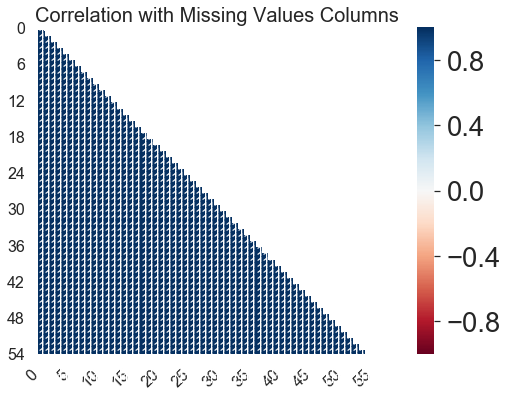

In [82]:
missing_value_columns = train_sampling_addition.columns[train_sampling_addition.isnull().any()].tolist()
msno.heatmap(train_sampling_addition[missing_value_columns], figsize=(8,6))
plt.title("Correlation with Missing Values Columns", fontsize = 20)

- Original feature와 additional feature를 분리해서 correlation 확인

In [84]:
train_sampling_addition[missing_value_columns].corr()
train_sampling_addition[train_sampling_addition[missing_value_columns].corr() > 0.5]

,quarter,month,dayofweek,day,hour,minute,ci_month,co_month,ci_day,co_day,...,49,50,51,52,53,54,55,56,57,58
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## srch_destination_id missing value 전략
- feature 간의 상관관계가 없고, 전체 dataset 중에서 missing value가 차지하는 비율이 매우 적음
- missing value를 처리하는 여러 방법 중, 제거하는 방법을 선택

In [87]:
train_sampling_addition.dropna(inplace=True)

In [88]:
for col in train_sampling_addition.columns:
    print(col, train_sampling_addition[col].isnull().sum())

quarter 0
month 0
dayofweek 0
day 0
hour 0
minute 0
ci_month 0
co_month 0
ci_day 0
co_day 0
ci_dayofweek 0
co_dayofweek 0
ci_quarter 0
co_quarter 0
duration_of_stay 0
site_name 0
posa_continent 0
user_location_country 0
user_location_region 0
user_location_city 0
orig_destination_distance 0
user_id 0
is_mobile 0
is_package 0
channel 0
srch_adults_cnt 0
srch_children_cnt 0
srch_rm_cnt 0
srch_destination_id 0
srch_destination_type_id 0
is_booking 0
cnt 0
hotel_continent 0
hotel_country 0
hotel_market 0
hotel_cluster 0
year 0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0


In [89]:
train_sampling_addition.describe()

,quarter,month,dayofweek,day,hour,minute,ci_month,co_month,ci_day,co_day,...,49,50,51,52,53,54,55,56,57,58
count,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,...,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06,1.245278e+06
mean,2.706570e+00,7.150688e+00,2.779674e+00,1.579059e+01,1.363353e+01,2.961546e+01,7.139471e+00,6.958479e+00,1.619448e+01,1.600491e+01,...,-9.186661e-04,-9.379420e-04,-2.180536e-04,2.548614e-04,8.010708e-04,1.340852e-04,1.890134e-04,3.745248e-04,1.581400e-04,2.572242e-05
std,1.066456e+00,3.262015e+00,1.997271e+00,8.743311e+00,5.657940e+00,1.730863e+01,3.365370e+00,3.404015e+00,8.874108e+00,9.008588e+00,...,1.685413e-02,1.654428e-02,1.210817e-02,1.015047e-02,9.767788e-03,6.544972e-03,6.647334e-03,7.016050e-03,4.434504e-03,2.588789e-03
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,-2.409961e-01,-2.397938e-01,-1.919475e-01,-2.860810e-01,-1.018862e-01,-1.505922e-01,-1.723210e-01,-1.569399e-01,-8.895885e-02,-1.247743e-01
25%,2.000000e+00,5.000000e+00,1.000000e+00,8.000000e+00,1.000000e+01,1.500000e+01,4.000000e+00,4.000000e+00,9.000000e+00,8.000000e+00,...,-1.858731e-03,-2.515940e-03,-1.600519e-03,-3.618973e-03,-2.847624e-03,-8.264213e-04,-9.185861e-04,-8.118544e-04,-9.174882e-04,-4.600120e-04
50%,3.000000e+00,7.000000e+00,3.000000e+00,1.600000e+01,1.400000e+01,3.000000e+01,7.000000e+00,7.000000e+00,1.600000e+01,1.600000e+01,...,3.466566e-04,-2.648432e-04,-2.239288e-04,9.622253e-04,-1.032203e-03,7.968234e-05,2.487613e-04,5.010670e-05,1.985080e-05,-1.032606e-04
75%,4.000000e+00,1.000000e+01,4.000000e+00,2.300000e+01,1.800000e+01,4.500000e+01,1.000000e+01,1.000000e+01,2.400000e+01,2.400000e+01,...,1.690306e-03,1.326592e-03,3.281993e-03,2.934580e-03,2.259493e-03,1.629101e-03,1.825654e-03,1.867499e-03,1.692519e-03,2.973983e-04
max,4.000000e+00,1.200000e+01,6.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01,1.200000e+01,1.200000e+01,3.100000e+01,3.100000e+01,...,2.989961e-01,2.114327e-01,1.871120e-01,3.107823e-01,2.282932e-01,1.200177e-01,1.570327e-01,1.780266e-01,1.959012e-01,2.030989e-01


# 2. Hotel cluster classification

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.model_selection import train_test_split 

## 2-0. Data preparation (recap)

### Train / Test split by train_sampling (ratio 80:20)
- month 기준으로 분할 (일 기준으로 나눌 수 있지만, 분석의 용이성을 높이고자)
- 24 month data를 8:2로 나누면, 대략 19 : 5 

In [91]:
train_new = train_sampling_addition[((train_sampling_addition.year == 2013) | ((train_sampling_addition.year == 2014) & (train_sampling_addition.month <= 7)))]
test_new = train_sampling_addition[((train_sampling_addition.year == 2014) & (train_sampling_addition.month >= 8))]
test_new = test_new[test_new.is_booking == 1]
test_new

,quarter,month,dayofweek,day,hour,minute,ci_month,co_month,ci_day,co_day,...,49,50,51,52,53,54,55,56,57,58
60,3,8,1,19,8,12,8,8,22,23,...,-0.002614,0.005141,-0.000049,0.002156,-0.005777,0.004707,-0.004103,-0.000945,0.001189,-0.000399
60,3,8,3,21,9,11,8,9,31,4,...,0.001058,0.002349,0.002636,-0.004965,-0.002395,-0.000871,-0.003291,0.010262,-0.001704,0.000396
60,3,8,4,15,17,39,8,8,21,23,...,0.000928,0.000237,-0.001249,0.001359,0.000712,-0.000771,0.000569,-0.000075,-0.000644,-0.000038
60,3,8,1,5,12,30,8,8,15,17,...,0.001833,-0.002440,0.003780,-0.001019,0.001424,0.001924,-0.001179,0.001810,0.000913,0.001024
60,4,11,2,12,15,43,12,12,5,8,...,-0.000694,0.000663,0.000367,0.004844,-0.002389,0.000897,-0.000576,-0.001718,-0.000916,0.000220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,4,11,1,11,22,27,11,11,27,30,...,-0.005583,-0.002793,-0.005284,0.001641,-0.002887,-0.000108,-0.002396,-0.001488,-0.000362,-0.001121
74,4,12,2,17,14,31,12,12,26,27,...,-0.005583,-0.002793,-0.005284,0.001641,-0.002887,-0.000108,-0.002396,-0.001488,-0.000362,-0.001121
74,4,10,6,26,23,23,1,1,22,26,...,-0.005583,-0.002793,-0.005284,0.001641,-0.002887,-0.000108,-0.002396,-0.001488,-0.000362,-0.001121
74,4,10,6,26,23,47,1,1,22,25,...,-0.005583,-0.002793,-0.005284,0.001641,-0.002887,-0.000108,-0.002396,-0.001488,-0.000362,-0.001121


In [93]:
print(check_nan(train_new))
print(check_nan(test_new))

   quarter			 Percent of NaN value: 0.00%
     month			 Percent of NaN value: 0.00%
 dayofweek			 Percent of NaN value: 0.00%
       day			 Percent of NaN value: 0.00%
      hour			 Percent of NaN value: 0.00%
    minute			 Percent of NaN value: 0.00%
  ci_month			 Percent of NaN value: 0.00%
  co_month			 Percent of NaN value: 0.00%
    ci_day			 Percent of NaN value: 0.00%
    co_day			 Percent of NaN value: 0.00%
ci_dayofweek			 Percent of NaN value: 0.00%
co_dayofweek			 Percent of NaN value: 0.00%
ci_quarter			 Percent of NaN value: 0.00%
co_quarter			 Percent of NaN value: 0.00%
duration_of_stay			 Percent of NaN value: 0.00%
 site_name			 Percent of NaN value: 0.00%
posa_continent			 Percent of NaN value: 0.00%
user_location_country			 Percent of NaN value: 0.00%
user_location_region			 Percent of NaN value: 0.00%
user_location_city			 Percent of NaN value: 0.00%
orig_destination_distance			 Percent of NaN value: 0.00%
   user_id			 Percent of NaN value: 0.00%
 is_mobile			 Perc

In [95]:
def make_label(df, target):
    x = df.drop(target, axis=1).values
    y = df[target].values
    
    return x, y

train_x, train_y = make_label(train_new, 'hotel_cluster')
print(train_x.shape)
print(train_y.shape)

valid_x, valid_y = make_label(test_new, 'hotel_cluster')
print(valid_x.shape)
print(valid_y.shape)

(786066, 95)
(786066,)
(32731, 95)
(32731,)


## 2-1. Random forest classifier

In [97]:
RFC = RandomForestClassifier()
RFC.fit(train_x, train_y)
rfc_prediction = RFC.predict(valid_x)
print('Validation set ({}명) Accuracy : {:.2f}%'.format(valid_y.shape[0], 100 * metrics.accuracy_score(rfc_prediction, valid_y)))

Validation set (32731명) Accuracy : 22.91%


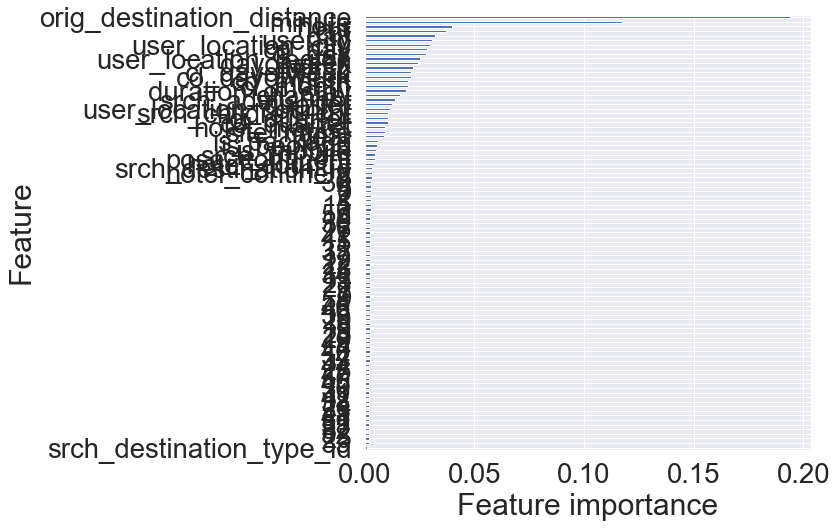

In [107]:
from pandas import Series
# print(train_new.drop('hotel_cluster', axis=1).columns)
feature_importance = RFC.feature_importances_
Series_feat_imp = Series(feature_importance, index=train_new.drop('hotel_cluster', axis=1).columns)

plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()